# BoolQ - BERT - Main file

In [1]:
from datasets import load_dataset
import torch
import numpy as np
import pickle
import json
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import io
import PIL
from PIL import Image, ImageEnhance
import pickle
import gc

In [ ]:
# Transform for CNN
from torchvision import transforms
input_size = 224

transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Resize all images to the same size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, input_size=input_size):
        super(SimpleCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 5
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.act5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adjusted size calculation after 5 pooling layers
        size_after_conv = input_size // 32  # Each pooling layer halves the dimension
        self.fc1 = nn.Linear(256 * size_after_conv * size_after_conv, num_classes)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = self.pool5(self.act5(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
dataset = load_dataset("boolq")

In [ ]:
input_pairs = [[row['question'], row['passage']] for row in dataset['train']]

In [ ]:
# Model link and tokenizer
model_link = "rycecorn/distil-bert-fine-tuned-boolq"
tokenizer = AutoTokenizer.from_pretrained(model_link)
model = AutoModelForSequenceClassification.from_pretrained(model_link, output_attentions=True)

In [ ]:
def get_self_attention_matrix(input_sentence, attention_head):
    test = input_pairs[input_sentence]
    tokenized_input = tokenizer(test[0], test[1], truncation=True, padding=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
      outputs = model(**tokenized_input)
    attention_outputs = torch.stack(outputs.attentions)
    flattened_attention_matrices = attention_outputs.view(-1, attention_outputs.size(3), attention_outputs.size(4))
    flattened_attention_matrices = flattened_attention_matrices
    
    selected_attention_head = flattened_attention_matrices[attention_head].cpu().numpy()
    
      # Clear intermediate variables
    del test, tokenized_input, outputs, attention_outputs, flattened_attention_matrices
    torch.cuda.empty_cache()
    gc.collect()
    return selected_attention_head

In [ ]:
def classify_head_pattern(attention_pattern):
    # plot attention pattern
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_pattern, cmap='magma', interpolation='nearest')
    
    #Convert to bytes and to image file
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.clf()
    plt.close()
    buf.seek(0)
    png_variable = buf.getvalue()
    image_buffer = io.BytesIO(png_variable)
    
    # Close buffer - delete from memory
    buf.close()
    
    # Prep image for CNN
    img = PIL.Image.open(image_buffer)
    imgCropped = img.crop(box= (205, 96, 820, 713))
    enhancer = PIL.ImageEnhance.Contrast(imgCropped)
    enhanced_image = enhancer.enhance(4.0)
    gray_image = enhanced_image.convert("L")
    img = transform(gray_image.convert('RGB'))
    img = img.unsqueeze(0)
    
    # Clear intermediate variables and collect garbage
    del attention_pattern, png_variable, imgCropped, enhancer, enhanced_image, gray_image
    torch.cuda.empty_cache()
    gc.collect()
    
    return img

In [ ]:
model_cnn = torch.load('ahr_cnn_75_acc.pth')

In [ ]:
sentence_number = random.randint(0, 999)
head_number = random.randint(0, 73)
print(f'Input num: {sentence_number}')
print(f'Head num: {head_number}')

head_check = get_self_attention_matrix(sentence_number, head_number)
test_img = classify_head_pattern(head_check)

with torch.no_grad():
    output = model_cnn(test_img)
    _, predicted = torch.max(output, 1)
    print(f'Predicted class: {predicted.item()}') # Labels for classifier are range 0-4

In [ ]:
heads_to_prune = [34, 42, 29, 60, 59, 58, 43, 40, 44, 55, 53, 27, 51, 48, 50, 25, 45, 33, 49, 38, 52, 54, 31, 56, 39, 32, 36, 35, 37, 57, 28, 47, 63, 46, 70, 30, 16, 26, 15, 18, 64, 7, 68, 8, 71, 20, 62, 5, 24, 72, 66, 61, 12, 14, 6, 65, 67, 17, 1, 69, 23, 41, 10, 21, 9, 2, 19, 4]
attention_pattern_dict = {i: [0, 0, 0, 0, 0] for i in range(1, 73)}

In [ ]:
%%time
for head in tqdm(heads_to_prune, desc='head_count'):
    head_num_in_model = head - 1 # For index purpose
    i = 0
    while i != 80:
        sentence_number = random.randint(0, len(input_pairs) - 1)
        head_attention_matrix = get_self_attention_matrix(sentence_number, head_num_in_model)
        matrix_to_img = classify_head_pattern(head_attention_matrix)
        with torch.no_grad():
            output = model_cnn(matrix_to_img)
            _, predicted = torch.max(output, 1) # predicted.item() to get class

        # Update attention_pattern_dict
        attention_pattern_dict[head][predicted.item()] += 1
        i += 1
        # Clear variables and collect garbage
        del head_attention_matrix, matrix_to_img, output
        torch.cuda.empty_cache()
        gc.collect()

with open('distilbert_boolq_attention_prune_count.pickle', 'wb') as f:
    pickle.dump(attention_pattern_dict, f)

In [ ]:
file_path = 'distilbert_boolq_attention_prune_count.pickle'

# Open the pickle file and load the data
with open(file_path, 'rb') as file:
    test_attention_pattern = pickle.load(file)
    
test_attention_pattern

# Plot patterns for each head pruned

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
with open('bert_boolq_attention_prune_count_save.pickle', 'rb') as f:
    head_attention_count = pickle.load(f)

In [3]:
head_attention_count

{1: [261, 0, 1, 0, 238],
 2: [124, 37, 12, 33, 294],
 3: [0, 212, 288, 0, 0],
 4: [0, 0, 0, 0, 0],
 5: [156, 0, 0, 0, 344],
 6: [92, 142, 130, 49, 87],
 7: [29, 0, 2, 22, 447],
 8: [61, 0, 2, 1, 436],
 9: [1, 417, 78, 4, 0],
 10: [70, 5, 2, 0, 423],
 11: [0, 466, 34, 0, 0],
 12: [42, 263, 187, 2, 6],
 13: [209, 0, 1, 0, 290],
 14: [0, 175, 325, 0, 0],
 15: [493, 0, 1, 0, 6],
 16: [494, 0, 0, 0, 6],
 17: [0, 0, 0, 0, 0],
 18: [133, 70, 291, 3, 3],
 19: [0, 0, 0, 0, 0],
 20: [449, 3, 1, 0, 47],
 21: [466, 0, 0, 0, 34],
 22: [496, 0, 0, 0, 4],
 23: [11, 331, 157, 1, 0],
 24: [7, 74, 11, 2, 406],
 25: [0, 0, 0, 0, 0],
 26: [1, 121, 378, 0, 0],
 27: [496, 0, 0, 0, 4],
 28: [496, 0, 0, 0, 4],
 29: [467, 4, 26, 0, 3],
 30: [470, 0, 12, 0, 18],
 31: [4, 320, 53, 0, 123],
 32: [461, 3, 10, 3, 23],
 33: [491, 2, 5, 0, 2],
 34: [0, 0, 0, 0, 0],
 35: [427, 0, 0, 0, 73],
 36: [73, 133, 294, 0, 0],
 37: [184, 0, 44, 0, 272],
 38: [265, 0, 193, 0, 42],
 39: [69, 1, 360, 0, 70],
 40: [0, 2, 469, 0, 29

In [4]:
with open('BoolQ_BERT_prune_interval.pkl', 'rb') as f:
    head_prune_intervals = pickle.load(f)

In [5]:
head_prune_intervals

{0.05: [38, 44, 43, 41, 45, 65, 39],
 0.1: [51, 81, 143, 142, 137, 133, 141],
 0.15: [136, 135, 138, 140, 139, 134, 144, 50],
 0.2: [53, 96, 66, 126, 92, 55, 58],
 0.25: [91, 80, 132, 57, 69, 72, 52],
 0.3: [83, 131, 76, 123, 122, 47, 73],
 0.35: [88, 37, 49, 56, 74, 64, 61],
 0.4: [67, 128, 103, 130, 75, 87, 22, 121],
 0.45: [124, 127, 59, 109, 63, 54, 28],
 0.5: [82, 62, 68, 125, 95, 8, 21],
 0.55: [129, 13, 78, 31, 116, 112, 94],
 0.6: [99, 115, 27, 5, 1, 10, 86],
 0.65: [7, 97, 29, 40, 60, 79, 100, 32],
 0.7: [35, 102, 70, 84, 6, 93, 2],
 0.75: [18, 33, 24, 15, 77, 90, 20],
 0.8: [101, 36, 48, 89, 12, 119, 114],
 0.85: [98, 30, 16, 85, 110, 71, 26],
 0.9: [9, 118, 117, 104, 23, 106, 108, 46],
 0.95: [113, 120, 105, 3, 111, 11, 14]}

In [6]:
pruned_heads_attention_pattern_count = {i: [0, 0, 0, 0, 0] for i in np.around(np.arange(0, 0.96, 0.05), 2)}

In [7]:
for i in head_prune_intervals:
    for head in head_prune_intervals[i]:
        pruned_heads_attention_pattern_count[i] = [a + b for a, b in zip(head_attention_count[head], pruned_heads_attention_pattern_count[i])]

In [8]:
pruned_heads_attention_pattern_count

{0.0: [0, 0, 0, 0, 0],
 0.05: [1797, 1, 1389, 0, 313],
 0.1: [1322, 494, 335, 0, 1349],
 0.15: [1496, 100, 187, 0, 2217],
 0.2: [1655, 1, 1344, 0, 500],
 0.25: [1383, 3, 1475, 0, 639],
 0.3: [1097, 41, 1374, 0, 988],
 0.35: [1413, 7, 1675, 0, 405],
 0.4: [1212, 2, 1683, 0, 1103],
 0.45: [1361, 12, 1347, 0, 780],
 0.5: [767, 35, 1837, 1, 860],
 0.55: [558, 330, 1742, 0, 870],
 0.6: [1486, 5, 899, 0, 1110],
 0.65: [1300, 18, 2090, 25, 567],
 0.7: [747, 268, 1887, 82, 516],
 0.75: [1886, 152, 952, 5, 505],
 0.8: [1096, 458, 1836, 2, 108],
 0.85: [1617, 145, 1622, 1, 115],
 0.9: [948, 784, 1826, 5, 437],
 0.95: [1472, 854, 997, 0, 177]}

In [9]:
# Function to calculate cumulative dictionary
def calculate_cumulative(attention_patterns):
    cumulative_patterns = {}
    cumulative_sum = [0, 0, 0, 0, 0]

    for key in sorted(attention_patterns.keys()):
        cumulative_sum = [a + b for a, b in zip(cumulative_sum, attention_patterns[key])]
        cumulative_patterns[key] = cumulative_sum.copy()
    
    return cumulative_patterns

cumulative_patterns = calculate_cumulative(pruned_heads_attention_pattern_count)
cumulative_patterns

{0.0: [0, 0, 0, 0, 0],
 0.05: [1797, 1, 1389, 0, 313],
 0.1: [3119, 495, 1724, 0, 1662],
 0.15: [4615, 595, 1911, 0, 3879],
 0.2: [6270, 596, 3255, 0, 4379],
 0.25: [7653, 599, 4730, 0, 5018],
 0.3: [8750, 640, 6104, 0, 6006],
 0.35: [10163, 647, 7779, 0, 6411],
 0.4: [11375, 649, 9462, 0, 7514],
 0.45: [12736, 661, 10809, 0, 8294],
 0.5: [13503, 696, 12646, 1, 9154],
 0.55: [14061, 1026, 14388, 1, 10024],
 0.6: [15547, 1031, 15287, 1, 11134],
 0.65: [16847, 1049, 17377, 26, 11701],
 0.7: [17594, 1317, 19264, 108, 12217],
 0.75: [19480, 1469, 20216, 113, 12722],
 0.8: [20576, 1927, 22052, 115, 12830],
 0.85: [22193, 2072, 23674, 116, 12945],
 0.9: [23141, 2856, 25500, 121, 13382],
 0.95: [24613, 3710, 26497, 121, 13559]}

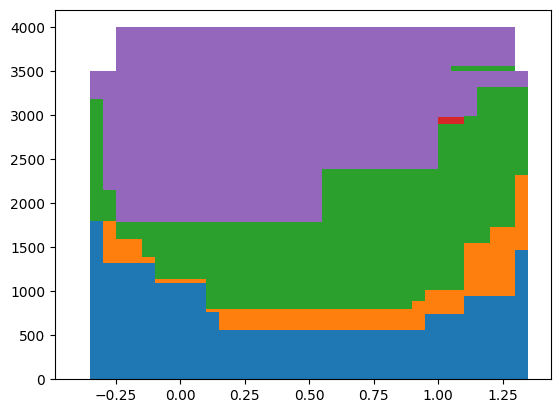

In [9]:
data = pruned_heads_attention_pattern_count
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# The keys of the dictionary are the x positions of the bars
x = list(data.keys())

# Stack the values from the dictionary and plot the bars
bottom = [0] * len(x)
for values in zip(*data.values()):
    ax.bar(x, values, bottom=bottom)
    bottom = [b + v for b, v in zip(bottom, values)]

plt.show()

In [ ]:
'''import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

# Initialize Plotly to run offline in Jupyter notebooks
init_notebook_mode(connected=True)

# Convert dictionary to list for plotting
labels = list(data.keys())
values = list(data.values())

# Create figure
fig = go.Figure()

# Add traces for each category
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
for i in range(len(categories)):
    fig.add_trace(go.Bar(
        x=labels,
        y=[val[i] for val in values],
        name=categories[i]
    ))

# Update layout for better spacing
fig.update_layout(
    barmode='stack',
    xaxis=dict(type='category', tickvals=labels),
    title='Interactive Stacked Bar Chart',
    xaxis_title='Key',
    yaxis_title='Value'
)

# Show the figure
iplot(fig)'''

/tmp/ipykernel_363/200933646.py:8: RuntimeWarning: invalid value encountered in divide
  proportions = values / values.sum(axis=1, keepdims=True)


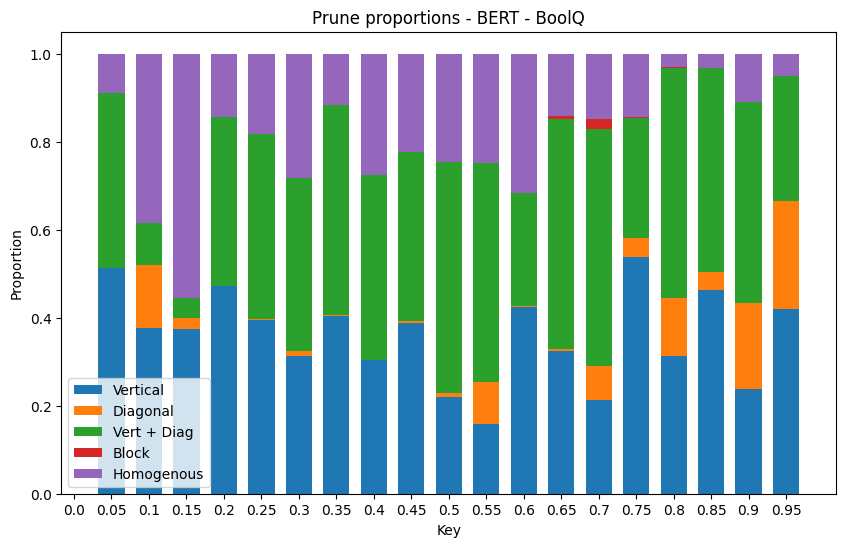

In [11]:
# Updated code to plot with specified modifications

# Convert dictionary to list for plotting
labels = list(data.keys())
values = np.array(list(data.values()))

# Calculate proportions
proportions = values / values.sum(axis=1, keepdims=True)

# Define new category labels
category_labels = ['Vertical', 'Diagonal', 'Vert + Diag', 'Block', 'Homogenous']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Increased the height of the figure to 12

# Define bar width and positions
bar_width = 0.8  # Increased the bar width
x = np.arange(len(labels))

# Plot stacked bar chart with proportions
bottom = np.zeros(len(labels))
for i in range(proportions.shape[1]):
    ax.bar(x, proportions[:, i], bar_width, bottom=bottom, label=category_labels[i])
    bottom += proportions[:, i]

# Add labels and title
ax.set_xlabel('Key')
ax.set_ylabel('Proportion')
ax.set_title('Prune proportions - BERT - BoolQ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add space between bars
for bar in ax.patches:
    bar.set_x(bar.get_x() + 0.05)
    bar.set_width(bar.get_width() - 0.1)

plt.savefig('/home/jovyan/Thesis/ahr_pattern_prune_analysis/outputs/pruned_props_BERT_BoolQ.png')
plt.show()


# Cumulative pattern plot

/tmp/ipykernel_339/1923245737.py:8: RuntimeWarning: invalid value encountered in divide
  proportions = values / values.sum(axis=1, keepdims=True)


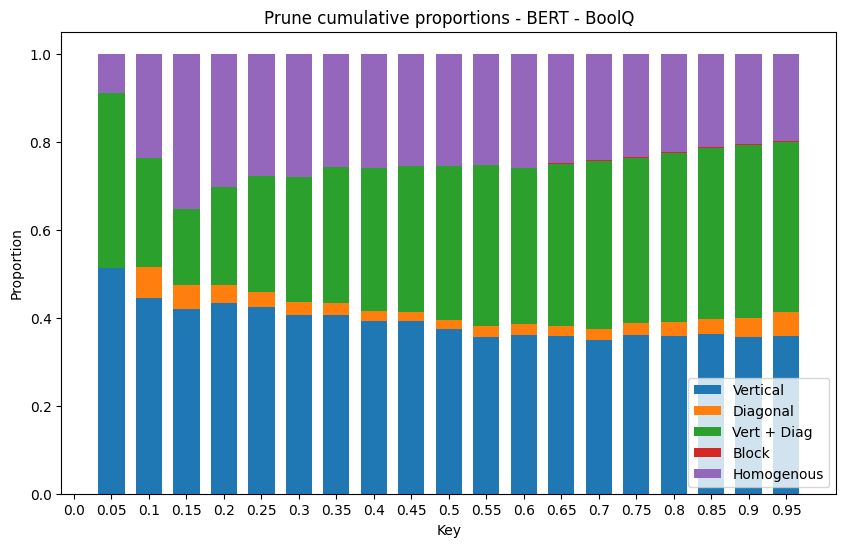

In [11]:
# Updated code to plot with specified modifications

# Convert dictionary to list for plotting
labels = list(cumulative_patterns.keys())
values = np.array(list(cumulative_patterns.values()))

# Calculate proportions
proportions = values / values.sum(axis=1, keepdims=True)

# Define new category labels
category_labels = ['Vertical', 'Diagonal', 'Vert + Diag', 'Block', 'Homogenous']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Increased the height of the figure to 12

# Define bar width and positions
bar_width = 0.8  # Increased the bar width
x = np.arange(len(labels))

# Plot stacked bar chart with proportions
bottom = np.zeros(len(labels))
for i in range(proportions.shape[1]):
    ax.bar(x, proportions[:, i], bar_width, bottom=bottom, label=category_labels[i])
    bottom += proportions[:, i]

# Add labels and title
ax.set_xlabel('Key')
ax.set_ylabel('Proportion')
ax.set_title('Prune cumulative proportions - BERT - BoolQ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add space between bars
for bar in ax.patches:
    bar.set_x(bar.get_x() + 0.05)
    bar.set_width(bar.get_width() - 0.1)

plt.savefig('/home/jovyan/Thesis/ahr_pattern_prune_analysis/outputs/cumu_props_BERT_BoolQ.png')
plt.show()


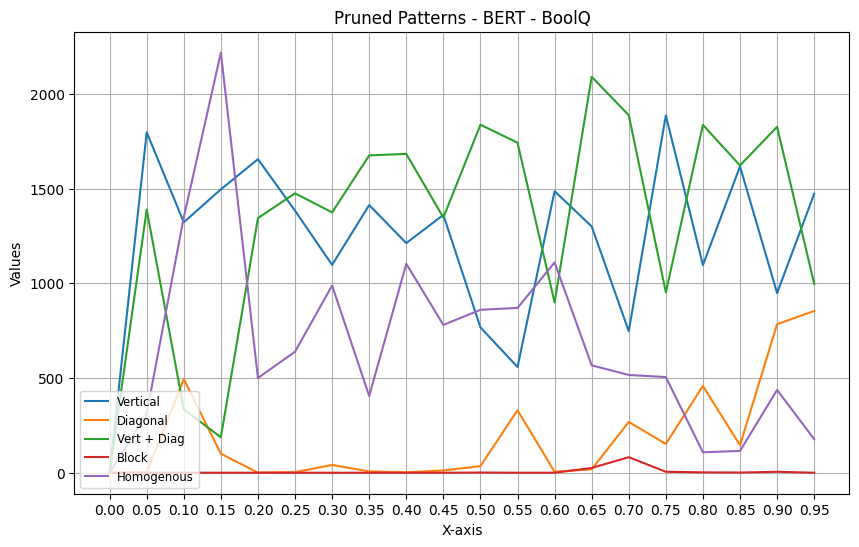

In [12]:
# Extracting keys and values
x = list(data.keys())
y_values = list(zip(*data.values()))

# Plotting the data with the new labels and all ticks on the x-axis
plt.figure(figsize=(10, 6))

for y in y_values:
    plt.plot(x, y)

plt.xlabel('X-axis')
plt.ylabel('Values')
plt.title('Pruned Patterns - BERT - BoolQ')
plt.xticks(x)  # Show all ticks on the x-axis
plt.legend(['Vertical', 'Diagonal', 'Vert + Diag', 'Block', 'Homogenous'], loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('/home/jovyan/Thesis/ahr_pattern_prune_analysis/outputs/pruned_patterns_BERT_BoolQ.png')
plt.show()